In [1]:
import matplotlib.pyplot as plt
from lienp.datasets.gpcurve import RBFCurve, MaternCurve, PeriodicCurve
import torch.nn as nn
from gpytorch.kernels import ScaleKernel, RBFKernel
from lienp.liegroups import T
from lienp.modules import *
import torch
from gpytorch.distributions import MultivariateNormal
from lienp.models import OracleGP,CNP
torch.manual_seed(1234)

In [2]:
class ConvCNP(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()

        self.x_dim = x_dim

        self.density = 16

        self.psi = ScaleKernel(RBFKernel())
        self.phi = PowerFunction(K=1)

        self.pre_mlp = nn.Sequential(
            nn.Linear(3, 8),
            nn.Sigmoid(),
        )

        self.cnn = nn.Sequential(
            nn.Conv1d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.Conv1d(32, 16, 5, 1, 2),
            nn.ReLU(),
            nn.Conv1d(16, 8, 5, 1, 2),
            nn.ReLU(),
        )

        def weights_init(m):
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                torch.nn.init.zeros_(m.bias)
        self.cnn.apply(weights_init)
        self.pre_mlp.apply(weights_init)

        self.psi_rho = ScaleKernel(RBFKernel())

        self.mean_linear = nn.Linear(8, 1)
        self.var_linear = nn.Sequential(
            nn.Linear(8, 1),
            nn.Softplus()
        )
        self.mean_linear.apply(weights_init)
        self.var_linear.apply(weights_init)


    def forward(self, batch_ctx, xt):
        xc, yc = batch_ctx
        # t = self.t.repeat(xc.size(0), 1, 1).to(xc.device)
        tmp = torch.cat([xc.reshape(-1), xt.reshape(-1)])
        lower, upper = tmp.min(), tmp.max()
        num_t = max(int((32 * (upper - lower)).item()), 1)
        t = torch.linspace(start=lower, end=upper, steps=num_t, device=xc.device).reshape(1, -1, self.x_dim).repeat(xc.size(0), 1, 1)

        h = self.psi(t, xc).matmul(self.phi(yc))
        h0, h1 = h.split(1, -1)
        h1 = h1.div(h0 + 1e-8)

        h = torch.cat([t, h0, h1], -1)
        h = self.pre_mlp(h).transpose(-1, -2)
        f = self.cnn(h).transpose(-1, -2)

        f = self.psi_rho(xt, t).matmul(f)
        mean = self.mean_linear(f).squeeze(-1)
        var = self.var_linear(f).squeeze(-1).diag_embed()
        return mean, var

In [3]:
class GConvCNP(nn.Module):
    def __init__(self, x_dim=1, y_dim=1, num=10, group=T(1)):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.group = group
        self.psi = ScaleKernel(RBFKernel())
        self.phi = PowerFunction()
        self.prelinear = nn.Sequential(
            Apply(nn.Linear(3, 8)),
            Apply(nn.Sigmoid())
        )

        self.conv = nn.Sequential(
            LieConv(8, 16, num_nbhd=25, fill=num/64, sampling_fraction=1., group=group, use_bn=True, mean=True),
            Apply(nn.ReLU()),
            LieConv(16, 32, num_nbhd=25, fill=num/64, sampling_fraction=1., group=group, use_bn=True, mean=True),
            Apply(nn.ReLU()),
            LieConv(32, 16, num_nbhd=25, fill=num/64, sampling_fraction=1., group=group, use_bn=True, mean=True),
            Apply(nn.ReLU()),
            LieConv(16, 8, num_nbhd=25, fill=num/64, sampling_fraction=1., group=group, use_bn=True, mean=True),
            Apply(nn.ReLU()),
        )

        self.psi_rho = ScaleKernel(RBFKernel())

        self.mean_linear = nn.Linear(8, 1)
        self.var_linear = nn.Sequential(
            nn.Linear(8, 1),
            nn.Softplus()
        )

    def forward(self, ctx, tgt_coords):
        ctx_coords, ctx_values = ctx

        tmp = torch.cat([ctx_coords.reshape(-1), tgt_coords.reshape(-1)])
        lower, upper = tmp.min() - 0.1, tmp.max() + 0.1
        num_t = max(int((32 * (upper - lower)).item()), 1)
        t_coords = torch.linspace(start=lower, end=upper, steps=num_t, device=ctx_coords.device).reshape(1, -1, self.x_dim).repeat(ctx_coords.size(0), 1, 1)

        t_coords = torch.cat([t_coords, tgt_coords], 1)
        h = self.psi(t_coords, ctx_coords).matmul(self.phi(ctx_values))
        h0, h1 = h.split(1, -1)
        h1 = h1.div(h0 + 1e-8)

        t_values = torch.cat([t_coords, h0, h1], -1)
        t_mask = torch.ones(t_values.shape[:2], dtype=torch.bool, device=t_values.device)

        lifted_t = self.group.lift((t_coords, t_values, t_mask), 1)
        lifted_t = self.prelinear(lifted_t)

        _, f, _ = self.conv(lifted_t)
        f = f[:, num_t:]
        mean = self.mean_linear(f).squeeze(-1)
        var = self.var_linear(f).squeeze(-1).diag_embed()
        return mean, var

/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43:

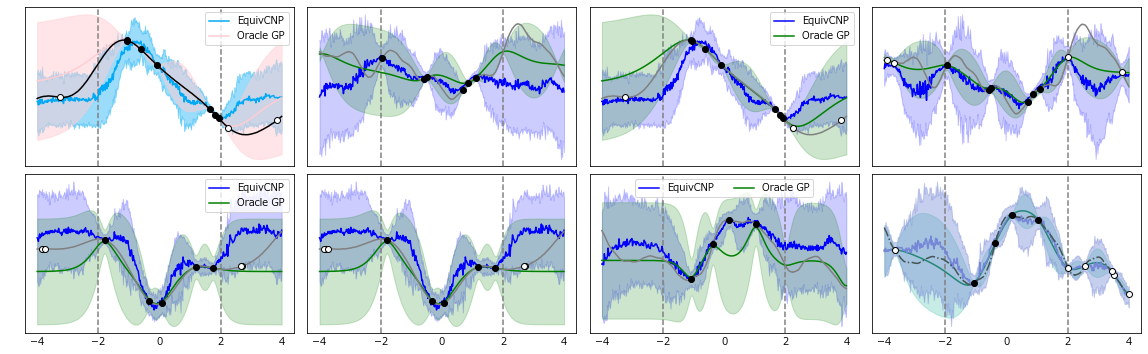

In [80]:
cnp_color = "#03A9F4"
gp_color = "#ffcdd2"
cnp = GConvCNP(num=12)
cnp.load_state_dict(torch.load("matern-fill12-64.pth"))
cnp = cnp.eval()
d = RBFCurve(train=False, data_range=(-4, 4))
d.length=200
dc, dt = d.sample(0, 10, 10)
within = (dc[0] <= 2) & (dc[0] >= -2)
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
    gp_result = gp(dt[0].unsqueeze(0))
gcnp = MultivariateNormal(*result)
gcnp_mean = gcnp.mean.squeeze()
gcnp_lower, gcnp_upper = gcnp.confidence_region()

gp_mean = gp_result.mean.squeeze()
gp_lower, gp_upper = gp_result.confidence_region()

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.subplot(241)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color=cnp_color, label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color=cnp_color, alpha=0.4)
plt.plot(dt[0], gp_mean, color=gp_color, label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color=gp_color, alpha=0.5)
plt.plot(dt[0], dt[1], color='black')
plt.plot(dc[0][within], dc[1][within], 'o', color='black')
plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff')
plt.legend(loc="upper right", ncol=1)
plt.yticks(color="None")
plt.xticks(color="None")
plt.tick_params(length=0)

plt.subplot(243)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color='blue', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='blue', alpha=0.2)
plt.plot(dt[0], gp_mean, color='green', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='green', alpha=0.2)
plt.plot(dt[0], dt[1], color='gray')
plt.plot(dc[0][within], dc[1][within], 'o', color='black')
plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff')
plt.legend(loc="upper right")
plt.yticks(color="None")
plt.xticks(color="None")
plt.tick_params(length=0)

cnp = GConvCNP(num=12)
cnp.load_state_dict(torch.load("matern-fill12-64.pth"))
cnp = cnp.eval()
d = MaternCurve(train=False, data_range=(-4, 4))
dc, dt = d.sample(0, 10, 10)
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
within = (dc[0] <= 2) & (dc[0] >= -2)
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
    gp_result = gp(dt[0].unsqueeze(0))
gcnp = MultivariateNormal(*result)
gcnp_mean = gcnp.mean.squeeze()
gcnp_lower, gcnp_upper = gcnp.confidence_region()

gp_mean = gp_result.mean.squeeze()
gp_lower, gp_upper = gp_result.confidence_region()


plt.subplot(242)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color='blue', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='blue', alpha=0.2)
plt.plot(dt[0], gp_mean, color='green', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='green', alpha=0.2)
plt.plot(dt[0], dt[1], color='gray')
plt.plot(dc[0][within], dc[1][within], 'o', color='black', label='Observation (in-bound)')
# plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff')
# plt.legend(loc="upper right")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.xticks(color="None")


gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
within = (dc[0] <= 2) & (dc[0] >= -2)
with torch.no_grad():
    result = cnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
    gp_result = gp(dt[0].unsqueeze(0))
gcnp = MultivariateNormal(*result)
gcnp_mean = gcnp.mean.squeeze()
gcnp_lower, gcnp_upper = gcnp.confidence_region()
gp_mean = gp_result.mean.squeeze()
gp_lower, gp_upper = gp_result.confidence_region()

plt.subplot(244)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color='blue', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='blue', alpha=0.2)
plt.plot(dt[0], gp_mean, color='green', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='green', alpha=0.2)
plt.plot(dt[0], dt[1], color='gray')
plt.plot(dc[0][within], dc[1][within], 'o', color='black', label='Observation (in-bound)')
plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff', label='Observation (out-bound)')
# plt.legend(loc="upper right")
plt.yticks(color="None")
plt.xticks(color="None")
plt.tick_params(length=0)

cnp = GConvCNP(num=12)
cnp.load_state_dict(torch.load("matern-fill12-64.pth"))
cnp = cnp.eval()
d = RBFCurve(train=False, data_range=(-4, 4))
dc, dt = d.sample(0, 10, 10)
within = (dc[0] <= 2) & (dc[0] >= -2)
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
    gp_result = gp(dt[0].unsqueeze(0))
gcnp = MultivariateNormal(*result)
gcnp_mean = gcnp.mean.squeeze()
gcnp_lower, gcnp_upper = gcnp.confidence_region()

gp_mean = gp_result.mean.squeeze()
gp_lower, gp_upper = gp_result.confidence_region()

plt.subplot(245)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color='blue', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='blue', alpha=0.2)
plt.plot(dt[0], gp_mean, color='green', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='green', alpha=0.2)
plt.plot(dt[0], dt[1], color='gray')
plt.plot(dc[0][within], dc[1][within], 'o', color='black')
plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff')
plt.legend(loc="upper right")
plt.yticks(color="None")
plt.tick_params(length=0)

plt.subplot(246)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color='blue', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='blue', alpha=0.2)
plt.plot(dt[0], gp_mean, color='green', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='green', alpha=0.2)
plt.plot(dt[0], dt[1], color='gray')
plt.plot(dc[0][within], dc[1][within], 'o', color='black')
plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff')
# plt.legend(loc="upper right")
plt.yticks(color="None")
plt.tick_params(length=0)

cnp = GConvCNP(num=12)
cnp.load_state_dict(torch.load("matern-fill12-64.pth"))
cnp = cnp.eval()
d = MaternCurve(train=False, data_range=(-4, 4))
dc, dt = d.sample(0, 10, 10)
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
within = (dc[0] <= 2) & (dc[0] >= -2)
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
    gp_result = gp(dt[0].unsqueeze(0))
gcnp = MultivariateNormal(*result)
gcnp_mean = gcnp.mean.squeeze()
gcnp_lower, gcnp_upper = gcnp.confidence_region()

gp_mean = gp_result.mean.squeeze()
gp_lower, gp_upper = gp_result.confidence_region()


plt.subplot(247)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gcnp_mean, color='blue', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='blue', alpha=0.2)
plt.plot(dt[0], gp_mean, color='green', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='green', alpha=0.2)
plt.plot(dt[0], dt[1], color='gray')
plt.plot(dc[0][within], dc[1][within], 'o', color='black')#, label='Observation (in)')
# plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff')
plt.legend(loc="upper center", ncol=3, fontsize=10)
plt.yticks(color="None")
plt.tick_params(length=0)


gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
within = (dc[0] <= 2) & (dc[0] >= -2)
with torch.no_grad():
    result = cnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
    gp_result = gp(dt[0].unsqueeze(0))
gcnp = MultivariateNormal(*result)
gcnp_mean = gcnp.mean.squeeze()
gcnp_lower, gcnp_upper = gcnp.confidence_region()
gp_mean = gp_result.mean.squeeze()
gp_lower, gp_upper = gp_result.confidence_region()

plt.subplot(248)
plt.axvline(x=-2, ls='--', color='gray') 
plt.axvline(x=2, ls='--', color='gray') 
plt.plot(dt[0], gp_mean, color='#228776', label='Oracle GP')
plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color='#45C1AA', alpha=0.3)
plt.plot(dt[0], gcnp_mean, color='#7587D6', label='EquivCNP')
plt.fill_between(dt[0].squeeze(), gcnp_lower.squeeze(), gcnp_upper.squeeze(), color='#7587D6', alpha=0.4)
plt.plot(dt[0], dt[1], '-.', color='#445555')
plt.plot(dc[0][within], dc[1][within], 'o', color='black', label='Observation (in-bound)')
plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff', label='Observation (out-bound)')
# plt.legend(loc="upper left")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.savefig("1d-reg.pdf", transparent=True, bbox_inches='tight', pad_inches=0)

In [4]:
def plot(dc, dt, within, gp_dist, cnp_dist, label="Model", axis=True):
#     gp_line = '#FFC000'
#     gp_area = '#FFC000'
#     cnp_line = '#7587D6'
#     cnp_area = '#7587D6'
    gp_line = '#B721FF'
    gp_area = '#B721FF'
    cnp_line = '#21D4FD'
    cnp_area = '#21D4FD'


    plt.axvline(x=-2, ls='--', color='gray') 
    plt.axvline(x=2, ls='--', color='gray') 
    plt.plot(dt[0], dt[1], '-.', color='#445555')

    gp_mean = gp_dist.mean.squeeze().detach()
    gp_lower, gp_upper = gp_dist.confidence_region()
    gp_lower, gp_upper = gp_lower.squeeze().detach(), gp_upper.squeeze().detach()   
    plt.plot(dt[0], gp_mean, color=gp_line, label='Oracle GP')
    plt.fill_between(dt[0].squeeze(), gp_lower.squeeze(), gp_upper.squeeze(), color=gp_area, alpha=0.2)
    
    cnp_mean = cnp_dist.mean.squeeze().detach()
    cnp_lower, cnp_upper = cnp_dist.confidence_region()
    cnp_lower, cnp_upper = cnp_lower.squeeze().detach(), cnp_upper.squeeze().detach()
    plt.plot(dt[0], cnp_mean, color=cnp_line, label=label)
    plt.fill_between(dt[0].squeeze(), cnp_lower.squeeze(), cnp_upper.squeeze(), color=cnp_area, alpha=0.2)
    
    plt.plot(dc[0][within], dc[1][within], 'o', color='black', label='Observation (in-bound)')
    plt.plot(dc[0][~within], dc[1][~within], 'o', color='#000000',markerfacecolor='#ffffff', label='Observation (out-bound)')
    # plt.legend(loc="upper left")
    plt.yticks(color="None")
    plt.ylim(-3, 3)
    if axis: plt.xticks(color="None")
    return plt.tick_params(length=0)

# plt.savefig("1d-reg-test.pdf", transparent=True, bbox_inches='tight', pad_inches=0)

/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)
/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


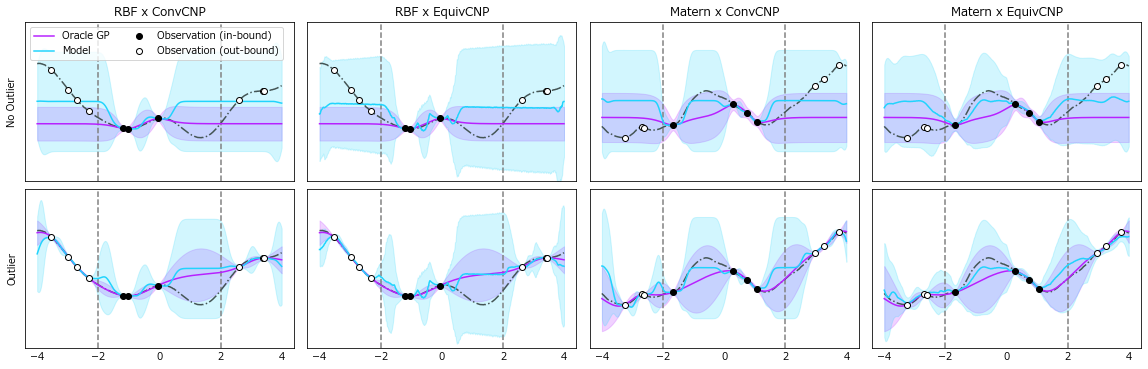

In [15]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()    #文字が重ならないよう調整
d = RBFCurve(train=False, data_range=(-4, 4))
d.length=200
dc, dt = d.sample(0, 10, 10)
within = (dc[0] <= 2) & (dc[0] >= -2)
gcnp = GConvCNP(num=4)
gcnp.load_state_dict(torch.load("weights/1dreg/eq/rbf_fill4.pth"))
gcnp = gcnp.eval()
cnp = ConvCNP(1, 1)
cnp.load_state_dict(torch.load('weights/1dreg/eq/rbf_convcnp.pth'))
cnp = cnp.eval()

# EQ x ConvCNP x inlier
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(241)
plt.title("RBF x ConvCNP")
plt.ylabel("No Outlier", labelpad=-10)
plot(dc, dt, within, gp_result, MultivariateNormal(*result))
plt.legend(loc='upper left', ncol=2)

# EQ x EquivCNP x inlier
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = gcnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(242)
plt.title("RBF x EquivCNP")
plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# EQ x ConvCNP x outlier
gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = cnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(245)
plt.ylabel("Outlier",labelpad=-10)
plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)


# EQ x EquivCNP x outlier
gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = gcnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(246)
plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)


######################################################################################
# Matern
d = MaternCurve(train=False, data_range=(-4, 4))
d.length=200
dc, dt = d.sample(0, 10, 10)
within = (dc[0] <= 2) & (dc[0] >= -2)
gcnp = GConvCNP(num=12)
gcnp.load_state_dict(torch.load("weights/1dreg/matern/matern-fill12-64.pth"))
gcnp = gcnp.eval()
cnp = ConvCNP(1, 1)
cnp.load_state_dict(torch.load('weights/1dreg/matern/matern_convcnp.pth'))
cnp = cnp.eval()

# Matern x ConvCNP x inlier
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(243)
plt.title("Matern x ConvCNP")
plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# Matern x EquivCNP x inlier
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = gcnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(244)
plt.title("Matern x EquivCNP")
plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# Matern x ConvCNP x outlier
gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = cnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(247)
plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)

# Matern x EquivCNP x outlier
gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = gcnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(248)
plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)

plt.savefig("1d-reg.pdf", transparent=True, bbox_inches='tight', pad_inches=0)

/Users/makora/.pyenv/versions/miniconda3-latest/envs/liecnp/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


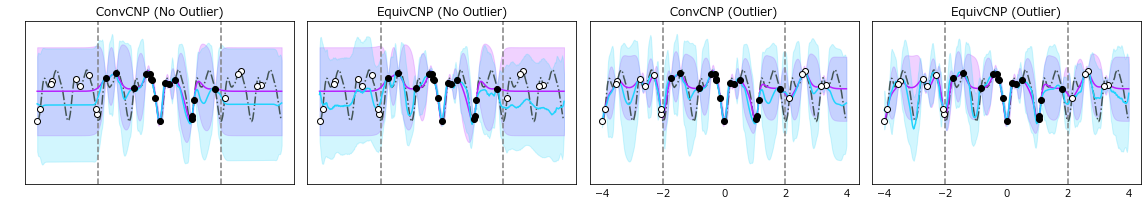

In [15]:
plt.figure(figsize=(20,3))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()    #文字が重ならないよう調整
d = PeriodicCurve(train=False, data_range=(-4, 4))
d.length=200
dc, dt = d.sample(0, 30, 10)
within = (dc[0] <= 2) & (dc[0] >= -2)
gcnp = GConvCNP(num=10)
gcnp.load_state_dict(torch.load("weights/1dreg/periodic/periodic_equivcnp_fill10.pth"))
gcnp = gcnp.eval()
cnp = ConvCNP(1, 1)
cnp.load_state_dict(torch.load('weights/1dreg/periodic/periodic_convcnp.pth'))
cnp = cnp.eval()

# EQ x ConvCNP x inlier
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(141)
plt.title("ConvCNP (No Outlier)")
# plt.ylabel("No Outlier", labelpad=-10)
plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# EQ x EquivCNP x inlier
gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = gcnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(142)
plt.title("EquivCNP (No Outlier)")
plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# EQ x ConvCNP x outlier
gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = cnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(143)
plt.title("ConvCNP (Outlier)")
# plt.ylabel("Outlier",labelpad=-10)
plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)


# EQ x EquivCNP x outlier
gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
with torch.no_grad():
    gp_result = gp(dt[0].unsqueeze(0))
with torch.no_grad():
    result = gcnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
plt.subplot(144)
plt.title("EquivCNP (Outlier)")
plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)


# ######################################################################################
# # Matern
# d = MaternCurve(train=False, data_range=(-4, 4))
# d.length=200
# dc, dt = d.sample(0, 10, 10)
# within = (dc[0] <= 2) & (dc[0] >= -2)
# gcnp = GConvCNP(num=12)
# gcnp.load_state_dict(torch.load("weights/1dreg/matern/matern-fill12-64.pth"))
# gcnp = gcnp.eval()
# cnp = ConvCNP(1, 1)
# cnp.load_state_dict(torch.load('weights/1dreg/matern/matern_convcnp.pth'))
# cnp = cnp.eval()

# # Matern x ConvCNP x inlier
# gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
# with torch.no_grad():
#     gp_result = gp(dt[0].unsqueeze(0))
# with torch.no_grad():
#     result = cnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
# plt.subplot(243)
# plt.title("Matern x ConvCNP")
# plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# # Matern x EquivCNP x inlier
# gp = OracleGP(dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1))
# with torch.no_grad():
#     gp_result = gp(dt[0].unsqueeze(0))
# with torch.no_grad():
#     result = gcnp((dc[0][within].reshape(1, -1, 1),dc[1][within].reshape(1, -1, 1)), dt[0].unsqueeze(0))
# plt.subplot(244)
# plt.title("Matern x EquivCNP")
# plot(dc, dt, within, gp_result, MultivariateNormal(*result))

# # Matern x ConvCNP x outlier
# gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
# with torch.no_grad():
#     gp_result = gp(dt[0].unsqueeze(0))
# with torch.no_grad():
#     result = cnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
# plt.subplot(247)
# plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)

# # Matern x EquivCNP x outlier
# gp = OracleGP(dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1))
# with torch.no_grad():
#     gp_result = gp(dt[0].unsqueeze(0))
# with torch.no_grad():
#     result = gcnp((dc[0].reshape(1, -1, 1),dc[1].reshape(1, -1, 1)), dt[0].unsqueeze(0))
# plt.subplot(248)
# plot(dc, dt, within, gp_result, MultivariateNormal(*result), axis=False)

plt.savefig("periodic.pdf", transparent=True, bbox_inches='tight', pad_inches=0)

# EQ

In [136]:
import warnings
warnings.simplefilter('ignore')
d = RBFCurve(train=False, data_range=(-4, 4))
d.length = 200

gcnp = GConvCNP(num=4)
gcnp.load_state_dict(torch.load("weights/1dreg/eq/rbf_fill4.pth"))
gcnp = gcnp.eval()
ccnp = ConvCNP(1, 1)
ccnp.load_state_dict(torch.load('weights/1dreg/eq/rbf_convcnp.pth'))
ccnp = ccnp.eval()
cnp = CNP(1, 1)
cnp.load_state_dict(torch.load('weights/1dreg/eq/rbf_cnp.pth'))
cnp = cnp.eval()

gp_result = []
gcnp_result = []
ccnp_result = []
cnp_result = []

for i in range(1000):
    observed_num = torch.randint(low=3, high=50, size=(1,)).item()
    dc, dt = d.sample(0, observed_num, 10)
    gp = OracleGP(dc[0].reshape(1, -1, 1), dc[1].reshape(1, -1, 1))
    with torch.no_grad():
        gp_result.append(gp(dt[0].unsqueeze(0)).log_prob(dt[1].squeeze().unsqueeze(0)))
        gcnp_result.append(MultivariateNormal(*gcnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
        ccnp_result.append(MultivariateNormal(*ccnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
        cnp_result.append(MultivariateNormal(*cnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))

In [137]:
gp_result = torch.cat(gp_result, 0) / 400
gp_result.mean(), gp_result.std()

(tensor(3.9335), tensor(0.5512))

In [138]:
gcnp_result = torch.cat(gcnp_result, 0) / 400
gcnp_result.mean(), gcnp_result.std()

(tensor(1.2930), tensor(1.0113))

In [139]:
ccnp_result = torch.cat(ccnp_result, 0) / 400
ccnp_result.mean(), ccnp_result.std()

(tensor(1.3271), tensor(1.0324))

In [140]:
cnp_result = torch.cat(cnp_result, 0) / 400
cnp_result.mean(), cnp_result.std()

(tensor(-1.7468), tensor(1.5415))

# Matern

In [142]:
d = MaternCurve(train=False, data_range=(-4, 4))
gcnp = GConvCNP(num=12)
gcnp.load_state_dict(torch.load("weights/1dreg/matern/matern-fill12-64.pth"))
gcnp = gcnp.eval()
ccnp = ConvCNP(1, 1)
ccnp.load_state_dict(torch.load('weights/1dreg/matern/matern_convcnp.pth'))
ccnp = ccnp.eval()
cnp = CNP(1, 1)
cnp.load_state_dict(torch.load('weights/1dreg/matern/matern_cnp.pth'))
cnp = cnp.eval()

gp_result = []
gcnp_result = []
ccnp_result = []
cnp_result = []

for i in range(1000):
    observed_num = torch.randint(low=3, high=50, size=(1,)).item()
    dc, dt = d.sample(0, observed_num, 10)
    gp = OracleGP(dc[0].reshape(1, -1, 1), dc[1].reshape(1, -1, 1))
    with torch.no_grad():
        gp_result.append(gp(dt[0].unsqueeze(0)).log_prob(dt[1].squeeze().unsqueeze(0)))
        gcnp_result.append(MultivariateNormal(*gcnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
        ccnp_result.append(MultivariateNormal(*ccnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
        cnp_result.append(MultivariateNormal(*cnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))

In [143]:
gp_result = torch.cat(gp_result, 0) / 400
gp_result.mean(), gp_result.std()

(tensor(3.7676), tensor(0.3542))

In [144]:
gcnp_result = torch.cat(gcnp_result, 0) / 400
gcnp_result.mean(), gcnp_result.std()

(tensor(0.6616), tensor(0.6728))

In [145]:
ccnp_result = torch.cat(ccnp_result, 0) / 400
ccnp_result.mean(), ccnp_result.std()

(tensor(0.8189), tensor(0.9366))

In [146]:
cnp_result = torch.cat(cnp_result, 0) / 400
cnp_result.mean(), cnp_result.std()

(tensor(-1.7808), tensor(1.3124))

# Periodic

In [151]:
d = PeriodicCurve(train=False, data_range=(-4, 4))
gcnp = GConvCNP(num=10)
gcnp.load_state_dict(torch.load("weights/1dreg/periodic/periodic_equivcnp_fill10.pth"))
gcnp = gcnp.eval()
ccnp = ConvCNP(1, 1)
ccnp.load_state_dict(torch.load('weights/1dreg/periodic/periodic_convcnp.pth'))
ccnp = ccnp.eval()
cnp = CNP(1, 1)
cnp.load_state_dict(torch.load('weights/1dreg/periodic/periodic_cnp.pth'))
cnp = cnp.eval()

gp_result = []
gcnp_result = []
ccnp_result = []
cnp_result = []
i = 0
while i < 1000:
    observed_num = torch.randint(low=3, high=50, size=(1,)).item()
    dc, dt = d.sample(0, observed_num, 10)
    try:
        gp = OracleGP(dc[0].reshape(1, -1, 1), dc[1].reshape(1, -1, 1))
        with torch.no_grad():
            gp_result.append(gp(dt[0].unsqueeze(0)).log_prob(dt[1].squeeze().unsqueeze(0)))
            gcnp_result.append(MultivariateNormal(*gcnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
            ccnp_result.append(MultivariateNormal(*ccnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
            cnp_result.append(MultivariateNormal(*cnp((dc[0].unsqueeze(0), dc[1].unsqueeze(0)), dt[0].unsqueeze(0))).log_prob(dt[1].squeeze().unsqueeze(0)))
        i += 1
    except:
        continue

In [152]:
gp_result = torch.cat(gp_result, 0) / 400
gp_result.mean(), gp_result.std()

(tensor(1.2194), tensor(5.6685))

In [155]:
gcnp_result = torch.cat(gcnp_result, 0) / 400
gcnp_result.mean(), gcnp_result.std()

(tensor(-0.4037), tensor(0.4968))

In [156]:
ccnp_result = torch.cat(ccnp_result, 0) / 400
ccnp_result.mean(), ccnp_result.std()

(tensor(-0.4787), tensor(0.5448))

In [157]:
cnp_result = torch.cat(cnp_result, 0) / 400
cnp_result.mean(), cnp_result.std()

(tensor(-1.0034), tensor(0.5174))